![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn-generation/conditional-char-rnn-generation.ipynb) builds on this model to add a category as input

# Prepare data

In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

 that counsel, to give forth
The corn o' the storehouse gratis, as 'twas used
Sometime in Greece,--

MENENIUS:
Well, well, no more of that.

CORIOLANUS:
Though there the people had more absolute power,


In [3]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

In [4]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Evaluating

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [7]:
import time, math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Then we define the training parameters, instantiate the model, and start training:

In [8]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 2
lr = 0.01

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output.view(-1), target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len
        
for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 32s (100 5%) 2.3376]
Whothe
You ther peam thabe me prear you to no the seee bear.

CEOSTRO:
Mo inme m thans to mer theese m 

 8s (200 10%) 2.0789]
Which in por mak my your is doobe as davesatle rey you mowrever, thered ip thrat ferrvath, tor pry pse 

 44s (300 15%) 2.5924]
Whion.

RORD:
Will fortoy itt if derest, say of my sites withers, of mime,
I I a I sirs, in in, way, t 

 15s (400 20%) 2.1664]
What do man my--
All main,
Doy him be lows,
As jome, the the stell shall dompice fuld what day;
Wice i 

 47s (500 25%) 1.8986]
Whall ad 'ting my weath bed ble talrecie
Geo in tall the the bive with ditius! Mild sere and of in unc 

 19s (600 30%) 2.0964]
Whendere, a ence comer bet cuter my
That this the quater men snotence,
The manie sut it swo this kinds 

 51s (700 35%) 2.0402]
Whe that to, that to to our fatless paresture
Crove and the, shall that ince to me watherused
To the t 

 23s (800 40%) 1.8453]
Whent, here a wrom on them?
Mive thwy lord, be for thounes in thee will, hims; whan

# Plotting the Network

Plotting the historical loss from all_losses shows the network learning:

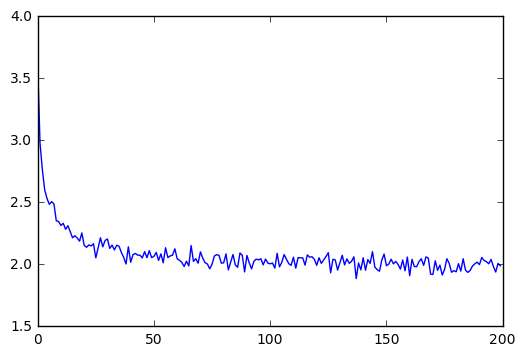

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In [13]:
print(evaluate('Th', 200, temperature=0.8))

Thy she forthard,
In you ster, do and lodges, of'll your han there so, own
in a where she cheres ince gorer'd'n is, it it of ance herew.

GNUS:
Yre's on man you lorgs and is here;
Yought wooker's of the


In [14]:
print(evaluate('Th', 200, temperature=0.2))

This with the should so some.

CORIOLANUS:
I word the so the here your some with the so court.

CORIOLANUS:
I with the so the so and with the mante shall the so the word the here.

CORIOLANUS:
I with th


In [15]:
print(evaluate('Th', 200, temperature=1.4))

Thournok'; thoy,
Musted! Witter''l?

BlOs jours, fweir?, wlorgn:
Gy, abmore sos yoo your:
S the should no? Mikhiou.-B
vooscomk is be
Amail.

CARUSTI:
GOOwAMI RoUTUSLIUITG; wor'd, that's,
BotcYem:
amolat
